In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchinfo import summary

import os
import pathlib
import shutil
import sys

/home/vedang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vedang/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [137]:
"""
Same dir structure as on Kaggle
input/
    lfw-dataset/
        csv files
        lfw-deepfunneled/
working/
    notebook
    data/
        train/
        val/
        test/
"""

'\nSame dir structure as on Kaggle\ninput/\n    lfw-dataset/\n        csv files\n        lfw-deepfunneled/\nworking/\n    notebook\n    data/\n        train/\n        val/\n        test/\n'

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99
# for modifications to use GPU

# Also this: https://github.com/pytorch/examples/blob/main/imagenet/main.py

cpu


In [3]:
data_folder = 'input/lfw-dataset/'

In [4]:
lfw_allnames = pd.read_csv(data_folder+"lfw_allnames.csv")

image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: str(x).zfill(4))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)

In [5]:
num_ppl = 10

print(image_paths['name'].value_counts()[:num_ppl])
list_people = list(image_paths['name'].value_counts()[:num_ppl].keys())
list_num_images = list(image_paths['name'].value_counts()[:num_ppl])
print(list_people, list_num_images)

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: name, dtype: int64
['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft'] [530, 236, 144, 121, 109, 77, 71, 60, 55, 53]


In [6]:
"""
num_for_each = image_paths['name'].value_counts()[num_ppl-1]
tmp_l = []
for name in list(image_paths['name'].value_counts()[:num_ppl].keys()):
    tmp_l.append(image_paths[image_paths.name==name].sample(num_for_each))
data = pd.concat(tmp_l)
print(data)
"""

"\nnum_for_each = image_paths['name'].value_counts()[num_ppl-1]\ntmp_l = []\nfor name in list(image_paths['name'].value_counts()[:num_ppl].keys()):\n    tmp_l.append(image_paths[image_paths.name==name].sample(num_for_each))\ndata = pd.concat(tmp_l)\nprint(data)\n"

In [7]:
num_for_each = image_paths['name'].value_counts()[num_ppl-1]
tmp_train = []
tmp_val = []
tmp_test = []
for name in list(image_paths['name'].value_counts()[:num_ppl].keys()):
    data_all = image_paths[image_paths.name==name].sample(num_for_each)
    data_train, data_test = train_test_split(data_all, test_size=0.2)
    data_train, data_val = train_test_split(data_train, test_size=0.2)
    tmp_train.append(data_train.copy())
    tmp_val.append(data_val.copy())
    tmp_test.append(data_test.copy())
data_train = pd.concat(tmp_train)
data_val = pd.concat(tmp_val)
data_test = pd.concat(tmp_test)
print(data_train.shape, data_val.shape, data_test.shape)


(330, 2) (90, 2) (110, 2)


In [8]:
data_root = './data/'

data_list = [data_train, data_val, data_test]
dirs = ['train', 'val', 'test']

# """             # (un)comment this line (only) and run, to copy

# # remove data directory if it exists
if os.path.exists(data_root) and os.path.isdir(data_root):
    shutil.rmtree(data_root)

transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1)
])

for i in range(len(dirs)):
    pathlib.Path(os.path.join(data_root, dirs[i])).mkdir(parents=True, exist_ok=True)
    
    data = data_list[i]

    for person in list_people:
        if len(data_train[data_train['name']==person])>0:
            pathlib.Path(os.path.join(data_root, dirs[i], person)).mkdir(parents=True, exist_ok=True)

    for im_path in data_list[i].image_path:
        name = data[data['image_path']==im_path]['name'].iloc[0]
        path_from = os.path.join(data_folder+'/lfw-deepfunneled/lfw-deepfunneled/', im_path)
        filename, file_extension = os.path.splitext(path_from.split('/')[-1])
        path_to = os.path.join(data_root, dirs[i], name)

        if not os.path.isfile(os.path.join(path_to, im_path)):
            shutil.copy(path_from, path_to)         # earlier (just copies image)
            
            # if dirs[i]!='test':                   # test-time augmentation too?
            img = Image.open(path_from)
            img = transform_augment(img)            # transformed image
            img.save(path_to+'/'+filename+'_transformed'+file_extension)

# """

In [9]:
train_path = os.path.join(data_root, dirs[0])
val_path = os.path.join(data_root, dirs[1])
test_path = os.path.join(data_root, dirs[2])

train_transform = transforms.Compose(transforms=[
    # transforms.RandomHorizontalFlip(),
    # transforms.Grayscale(num_output_channels=1),         # convert to grayscale
    transforms.ToTensor(),
    # transforms.Normalize(mean=0, std=255),      # output = (input-mean)/std
])
test_transform = transforms.Compose(transforms=[
    # transforms.Grayscale(num_output_channels=1),         # convert to grayscale
    transforms.ToTensor(),
    # transforms.Normalize(mean=0, std=255)
])

dataloader_kwargs = {
    'pin_memory': True,
    'num_workers': 1,
    'batch_size': 1,
    'shuffle': True
}
dataloader_kwargs_triplet = {
    'pin_memory': True,
    'num_workers': 1,
    'batch_size': 32,
    'shuffle': True
}
non_blocking = dataloader_kwargs['pin_memory']  # https://stackoverflow.com/questions/55563376/

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, train_transform), **dataloader_kwargs
)
train_loader_triplet = DataLoader(
    torchvision.datasets.ImageFolder(train_path, train_transform), **dataloader_kwargs
)
val_loader = DataLoader(
    torchvision.datasets.ImageFolder(val_path, test_transform), **dataloader_kwargs
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, test_transform), **dataloader_kwargs_triplet
)

In [10]:
for data in train_loader:
    print(data[0].shape, data[1].shape)
    # print(data[0], data[1])
    print(torch.mean(data[0]))
    break
# Total train data is of shape (128, 3, 250, 250)

torch.Size([1, 3, 250, 250]) torch.Size([1])
tensor(0.5325)


In [11]:
class FaceCNN_initial(nn.Module):
    def __init__(self, num_input_channels, num_classes, stride=1, padding=1):
        super().__init__()

        self.network = nn.Sequential(

        nn.Conv2d(in_channels=num_input_channels, out_channels=50, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=50, out_channels=20, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),

        nn.Flatten(),
        nn.Linear(in_features=20*125*125, out_features=num_classes)

        )

    def forward(self, input):
        output = self.network(input)
        return output

In [12]:
class FaceCNN(nn.Module):
    def __init__(self, num_input_channels, num_classes, stride=1, padding=1):
        super().__init__()

        self.encoder = nn.Sequential(

            # (250, 250, 3)

            nn.Conv2d(in_channels=num_input_channels, out_channels=64, kernel_size=7, stride=2, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2),

            nn.Flatten(),
            nn.Linear(in_features=14400, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # https://stats.stackexchange.com/questions/240305/
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(        
            nn.Dropout(p=0.5),
            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        output = self.decoder(encoded)
        return output, encoded

In [13]:
def triplet_loss(f, Y, num_classes, alpha=1, lam=0.01):
    # f is num_samples x 64
    # Y is categorical of size num_classes
    loss = 0
    for c in range(num_classes):
        p = f[Y==c]
        n = f[~(Y==c)]
        p_self = torch.sum((p[:,None,:]-p[None,:,:])**2, dim=2)
        p_n = torch.sum((p[:,None,:]-n[None,:,:])**2, dim=2)
        loss += torch.sum(torch.relu(p_self[:,:,None]-p_n[:,None,:]+alpha))
    return loss*lam

In [14]:
num_input_channels = 3
model = FaceCNN(num_input_channels=num_input_channels, num_classes=len(list_people)).to(device)
print(summary(model, input_size=(dataloader_kwargs['batch_size'], num_input_channels, 250, 250)))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

Layer (type:depth-idx)                   Output Shape              Param #
FaceCNN                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 64, 123, 123]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 123, 123]         128
│    └─ReLU: 2-3                         [1, 64, 123, 123]         --
│    └─MaxPool2d: 2-4                    [1, 64, 61, 61]           --
│    └─Dropout: 2-5                      [1, 64, 61, 61]           --
│    └─Conv2d: 2-6                       [1, 128, 61, 61]          73,856
│    └─BatchNorm2d: 2-7                  [1, 128, 61, 61]          256
│    └─ReLU: 2-8                         [1, 128, 61, 61]          --
│    └─MaxPool2d: 2-9                    [1, 128, 30, 30]          --
│    └─Dropout: 2-10                     [1, 128, 30, 30]          --
│    └─Conv2d: 2-11                      [1, 256, 30, 30]          295,168
│

In [15]:
def evaluate(loader, model):

    model.eval()

    score = 0
    cnt = 0

    with torch.no_grad():       # not training, so no need to calculate gradients
        for inputs, labels in loader:
            inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
            output, _ = model(inputs)
            _, pred = torch.max(output.data, 1)
            score += float(torch.sum(pred==labels.data))
            cnt += data[0].shape[0]

    return score/cnt

In [184]:
def train():
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        train_score = 0
        cnt = 0
        train_loss = 0

        model.train()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)

            optimizer.zero_grad()
            
            outputs,_ = model(inputs)
            
            # print(outputs, labels)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            train_score += float(torch.sum(preds==labels.data))
            cnt += inputs.shape[0]

            # print(preds, labels)

        for inputs, labels in train_loader_triplet:
            inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
            optimizer.zero_grad()
            _, encoded = model(inputs)
            loss = triplet_loss(encoded, labels, len(list_people))
            loss.backward()
            optimizer.step()
            

        train_acc = train_score/cnt
        val_acc = evaluate(val_loader, model)
        
        print("Epoch:", epoch, "\tLoss:", train_loss, "\tTraining Acc:", train_acc, "\tVal Acc:", val_acc)

        if val_acc > best_acc:
            torch.save(model.state_dict(),'best.model')
            best_acc = val_acc

In [185]:
train()

Epoch: 0 	Loss: 1527.853215932846 	Training Acc: 0.11969696969696969 	Val Acc: 0.13333333333333333
Epoch: 1 	Loss: 1489.5598942637444 	Training Acc: 0.1606060606060606 	Val Acc: 0.19444444444444445
Epoch: 2 	Loss: 1402.2740666419268 	Training Acc: 0.23484848484848486 	Val Acc: 0.2777777777777778
Epoch: 3 	Loss: 1301.2848310768604 	Training Acc: 0.2727272727272727 	Val Acc: 0.34444444444444444
Epoch: 4 	Loss: 1207.0473849140108 	Training Acc: 0.3393939393939394 	Val Acc: 0.3388888888888889
Epoch: 5 	Loss: 1094.2452965639532 	Training Acc: 0.38333333333333336 	Val Acc: 0.45
Epoch: 6 	Loss: 1014.6171431029215 	Training Acc: 0.43333333333333335 	Val Acc: 0.4666666666666667
Epoch: 7 	Loss: 909.8374981104862 	Training Acc: 0.5227272727272727 	Val Acc: 0.4777777777777778
Epoch: 8 	Loss: 840.92285978375 	Training Acc: 0.5393939393939394 	Val Acc: 0.49444444444444446
Epoch: 9 	Loss: 762.1023940009763 	Training Acc: 0.5954545454545455 	Val Acc: 0.6388888888888888
Epoch: 10 	Loss: 695.69629093853

In [18]:
model.load_state_dict(torch.load('best.model'))
model.eval()
score = 0
cnt = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        output, encoded = model(inputs)
        _, pred = torch.max(output.data, 1)
        score += float(torch.sum(pred==labels.data))
        cnt += data[0].shape[0]

print(score/cnt)

0.8045454545454546


In [19]:
model.load_state_dict(torch.load('best.model'))
model.eval()

arr_encoder = torch.zeros((2*data_test.shape[0],64))
arr_labels = torch.zeros((2*data_test.shape[0]))
idx = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        output, encoded = model(inputs)
        arr_encoder[idx] = encoded
        arr_labels[idx] = labels
        idx += 1

In [20]:
for c in range(num_ppl):
    p = arr_encoder[arr_labels==c]
    n = arr_encoder[~(arr_labels==c)]
    p_self = torch.mean(torch.sum((p[:,None,:]-p[None,:,:])**2, dim=2))
    p_n = torch.mean(torch.sum((p[:,None,:]-n[None,:,:])**2, dim=2))
    print(f"class : {c} closeness ratio : {p_self/p_n}")

class : 0 closeness ratio : 0.20108436048030853
class : 1 closeness ratio : 0.47010427713394165
class : 2 closeness ratio : 0.3403163254261017
class : 3 closeness ratio : 0.3014983832836151
class : 4 closeness ratio : 0.4799043834209442
class : 5 closeness ratio : 0.24377989768981934
class : 6 closeness ratio : 0.17014867067337036
class : 7 closeness ratio : 0.23948843777179718
class : 8 closeness ratio : 0.22940728068351746
class : 9 closeness ratio : 0.3937261700630188


## Adversarial attack

In [15]:
import math
import matplotlib.pyplot as plt

In [16]:
class Generator(nn.Module):
    def __init__(self, input_shape):
        super(Generator, self).__init__()
        self.noise = nn.Parameter(torch.randn(size = input_shape))
        # We attempt a simple strategy of adding constant noise to each image

    def forward(self, input):
        out = input + self.noise
        return out

In [18]:
model.load_state_dict(torch.load('best.model'))

<All keys matched successfully>

In [43]:
generator = Generator([1,3,250,250])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(generator.parameters(), lr=1e-3, weight_decay=1e-3)

### l2 regularized

In [19]:
def regularizer(image1, image2, lam = 1):
    return torch.mean((image1-image2)**2)*lam

In [ ]:
num_epochs = 6

Epoch: 0 	Loss: 11455821.10546875 	Training Acc: 0.22575757575757577 	Validation Acc: 0.2611111111111111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

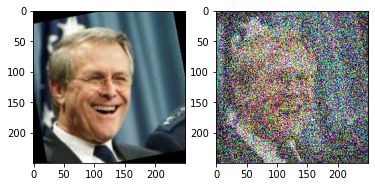

Epoch: 1 	Loss: 8633242.705078125 	Training Acc: 0.25303030303030305 	Validation Acc: 0.26666666666666666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

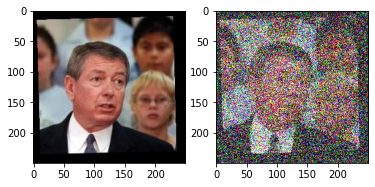

Epoch: 2 	Loss: 6506244.3232421875 	Training Acc: 0.2878787878787879 	Validation Acc: 0.29444444444444445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

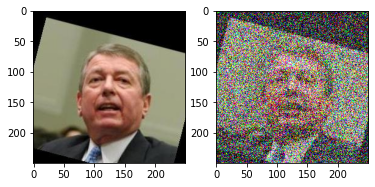

Epoch: 3 	Loss: 4903385.937011719 	Training Acc: 0.3151515151515151 	Validation Acc: 0.34444444444444444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

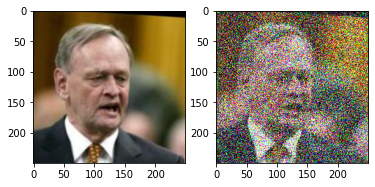

Epoch: 4 	Loss: 3695472.2973632812 	Training Acc: 0.35909090909090907 	Validation Acc: 0.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

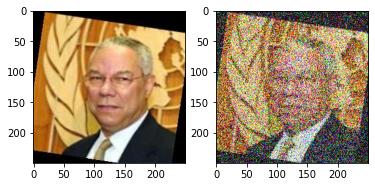

Epoch: 5 	Loss: 2785155.5463867188 	Training Acc: 0.4166666666666667 	Validation Acc: 0.4388888888888889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

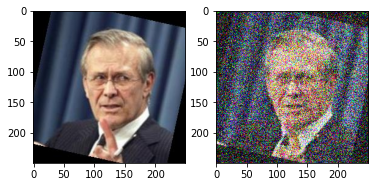

In [209]:
for epoch in range(num_epochs):
    train_score = 0
    cnt = 0
    train_loss = 0
    generator.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        optimizer.zero_grad()
        gen = generator(inputs)
        outputs,_ = model(gen)
        
        # print(outputs, labels)
        loss = -loss_fn(outputs, labels) + regularizer(inputs, gen, lam=2*1e4)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_score += float(torch.sum(preds==labels.data))
        cnt += inputs.shape[0]
        
    train_acc = train_score/cnt
    score = 0
    cnt = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
            output, encoded = model(generator(inputs))
            _, pred = torch.max(output.data, 1)
            score += float(torch.sum(pred==labels.data))
            cnt += data[0].shape[0]

    val_acc = (score/cnt)
    print("Epoch:", epoch, "\tLoss:", train_loss, "\tTraining Acc:", train_acc, "\tValidation Acc:", val_acc)
    with torch.no_grad():
        for inputs, labels in val_loader:
            plt.figure()
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(inputs[0].permute(1, 2, 0))
            axarr[1].imshow(generator(inputs)[0].permute(1, 2, 0).detach().numpy())
            plt.show(block=True)
            break


In [210]:
torch.save(generator.state_dict(),'generator2')

test acc: 0.35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

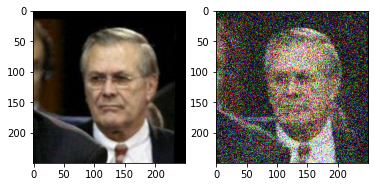

In [217]:
score = 0
cnt = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        output, encoded = model(generator(inputs))
        _, pred = torch.max(output.data, 1)
        score += float(torch.sum(pred==labels.data))
        cnt += data[0].shape[0]

print("test acc:", score/cnt)
for inputs, labels in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inputs[0].permute(1, 2, 0))
    axarr[1].imshow(generator(inputs)[0].permute(1, 2, 0).detach().numpy())
    break

### l1 regularized

In [44]:
def regularizer(image1, image2, lam = 1):
    return torch.mean(torch.abs(image1-image2))*lam

In [46]:
num_epochs = 6

Epoch: 0 	Loss: 51363.31446838379 	Training Acc: 0.5 	Validation Acc: 0.49444444444444446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

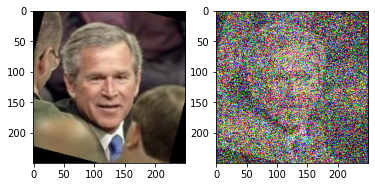

Epoch: 1 	Loss: 51120.46132659912 	Training Acc: 0.49393939393939396 	Validation Acc: 0.4388888888888889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

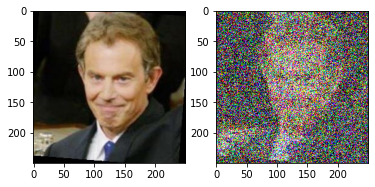

Epoch: 2 	Loss: 51074.299308776855 	Training Acc: 0.48787878787878786 	Validation Acc: 0.4222222222222222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

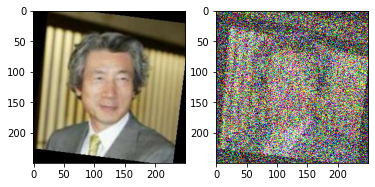

Epoch: 3 	Loss: 50844.28610229492 	Training Acc: 0.44393939393939397 	Validation Acc: 0.43333333333333335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

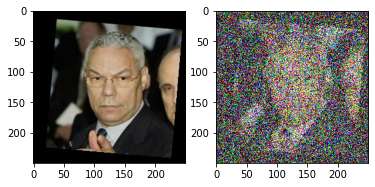

Epoch: 4 	Loss: 50738.260860443115 	Training Acc: 0.45151515151515154 	Validation Acc: 0.45555555555555555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

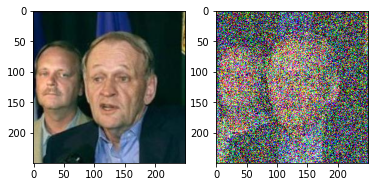

Epoch: 5 	Loss: 50566.25938415527 	Training Acc: 0.4318181818181818 	Validation Acc: 0.4222222222222222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

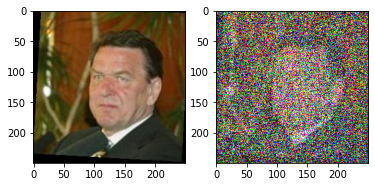

In [47]:
for epoch in range(num_epochs):
    train_score = 0
    cnt = 0
    train_loss = 0
    generator.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        optimizer.zero_grad()
        gen = generator(inputs)
        outputs,_ = model(gen)
        
        # print(outputs, labels)
        loss = -loss_fn(outputs, labels) + regularizer(inputs, gen, lam=1e2)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_score += float(torch.sum(preds==labels.data))
        cnt += inputs.shape[0]
        
    train_acc = train_score/cnt
    score = 0
    cnt = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
            output, encoded = model(generator(inputs))
            _, pred = torch.max(output.data, 1)
            score += float(torch.sum(pred==labels.data))
            cnt += data[0].shape[0]

    val_acc = (score/cnt)
    print("Epoch:", epoch, "\tLoss:", train_loss, "\tTraining Acc:", train_acc, "\tValidation Acc:", val_acc)
    with torch.no_grad():
        for inputs, labels in val_loader:
            plt.figure()
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(inputs[0].permute(1, 2, 0))
            axarr[1].imshow(generator(inputs)[0].permute(1, 2, 0).detach().numpy())
            plt.show(block=True)
            break

In [48]:
torch.save(generator.state_dict(),'generator1')

test acc: 0.38636363636363635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

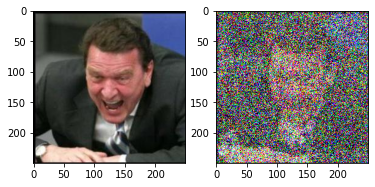

In [49]:
score = 0
cnt = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=non_blocking), labels.to(device, non_blocking=non_blocking)
        output, encoded = model(generator(inputs))
        _, pred = torch.max(output.data, 1)
        score += float(torch.sum(pred==labels.data))
        cnt += data[0].shape[0]

print("test acc:", score/cnt)
for inputs, labels in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inputs[0].permute(1, 2, 0))
    axarr[1].imshow(generator(inputs)[0].permute(1, 2, 0).detach().numpy())
    break

### Observations
l2 regularized attacks seem to fair better than l1 regularized at visual similarity i.e. need to add "less" noise for similar reduction in model accuracy